In [37]:
from datasets.f2fd_dataset import F2FD_DatasetV2
from torch.utils.data import DataLoader
from utils.utils import set_seed
from datasets import build_dataset
from hydra import initialize, compose
from omegaconf import OmegaConf


with initialize(version_base=None, config_path="configs/"):
    cfg = compose(config_name='config.yaml')

OmegaConf.set_struct(cfg, False)
cfg = OmegaConf.merge(cfg, cfg.method)

set_seed(cfg.seed)


dataset = build_dataset(cfg, test=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Fetch a batch
for batch in dataloader:
    # print(noisy_input.shape, noisy_target.shape)  # Should be (8, 1, 64, 64, 64)
    a = batch["raw_subtomo"]
    # b = batch["mask"]
    # b = batch[""]
    break
    # print(a.shape)


Seed set to 42


In [38]:
import torch

b_fft = torch.fft.fftn(a)
b_fft = torch.fft.fftshift(b_fft, dim=(-3, -2, -1))


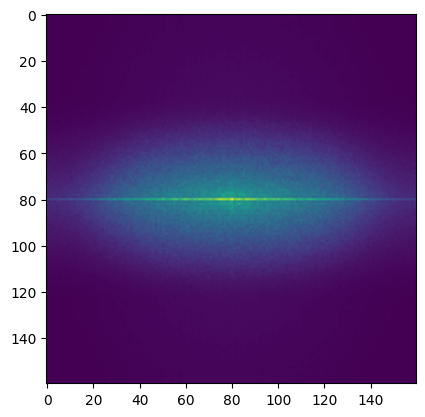

In [44]:
import matplotlib.pyplot as plt 

plt.imshow(b_fft[1, 0].abs().sum(dim=2))

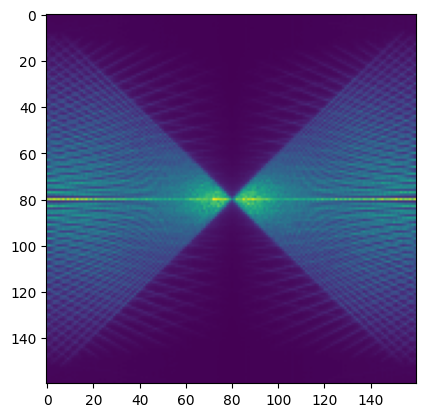

In [ ]:
dataset = build_dataset(cfg, val=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Fetch a batch
for batch in dataloader:
    # print(noisy_input.shape, noisy_target.shape)  # Should be (8, 1, 64, 64, 64)
    a = batch["raw_subtomo"]
    # b = batch["mask"]
    # b = batch[""]
    break
    # print(a.shape)

a_fft = torch.fft.fftn(a)
a_fft = torch.fft.fftshift(a_fft, dim=(-3, -2, -1))

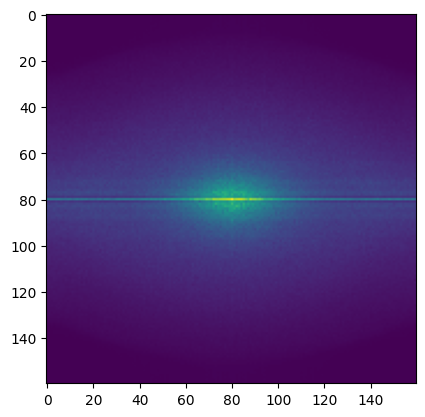

In [43]:
plt.imshow(a_fft[5, 0].abs().sum(dim=2))

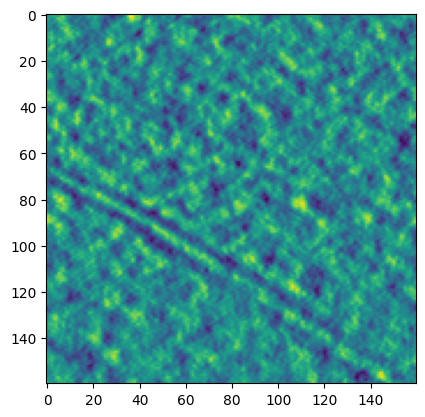

In [2]:
import matplotlib.pyplot as plt


plt.imshow(a[4, 0, 80])

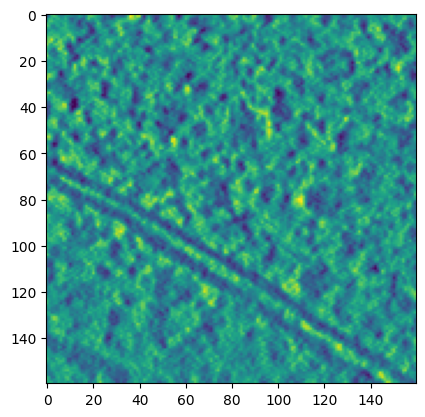

In [3]:
plt.imshow(b[4, 0, 80])

In [4]:
import torch
(kk == 1.0).sum() / kk.numel()

tensor(0.9000)

In [5]:
(kk == -1.0).sum() / kk.numel()

tensor(0.1000)

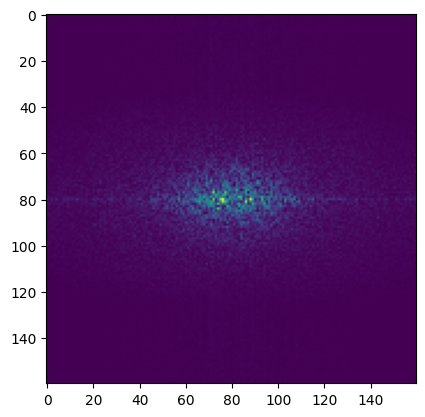

In [6]:
import torch

plt.imshow(torch.abs(full_fft_patch[2, :, :, :].sum(dim=-1)))

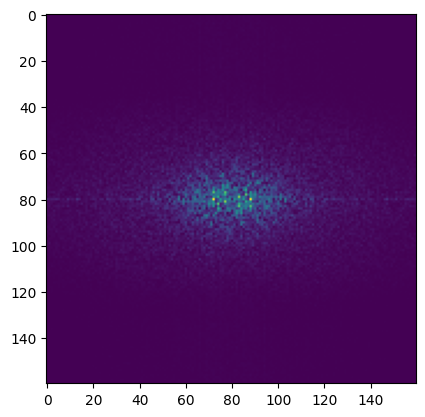

In [7]:
plt.imshow(torch.abs(debug_fft[2].sum(dim=-1)))

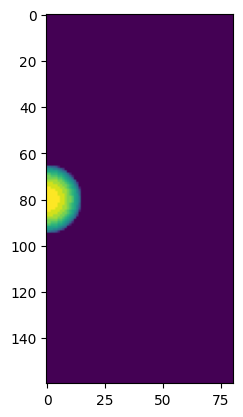

In [8]:
plt.imshow(mask[0, :, :, :].sum(axis=-3))

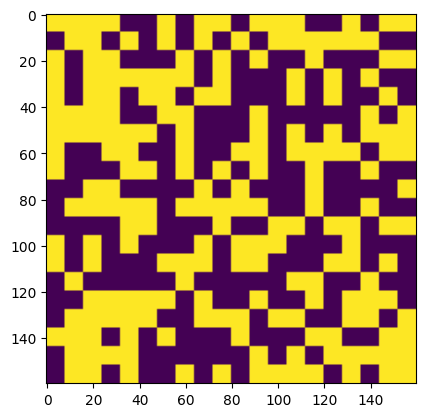

In [9]:
plt.imshow(overall_mask[0, ..., 70])

In [10]:
overall_mask.shape

torch.Size([8, 160, 160, 81])

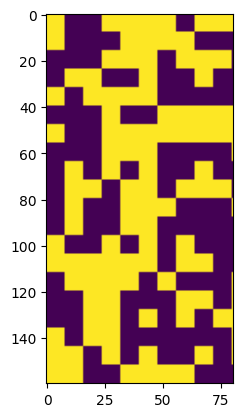

In [11]:
plt.imshow(overall_mask[0, 32])

In [12]:
import torch
import torch.nn.functional as F

loss = F.mse_loss(a, b)

print(loss)
torch.allclose(a, b)

tensor(0.8194)


False

In [13]:
a.mean()

tensor(0.0244)

In [6]:
import h5py


hdf5_file = "/media/ssd3/diyor/30-01-deepict-norm-256/work/training_data/def_val/037/partition.h5"
# hdf5_file = "/mnt/hdd_pool_zion/userdata/diyor/data/deepict/training/30-01-deepict-norm-256/work/training_data/def_val/037/partition.h5"

with h5py.File(hdf5_file, "r") as f:
    # for s in f.iter_chunks():
    #     arr = f[s]  # get numpy array for chunk
    #     print(arr.shape)
    for arr in f['volumes']['labels']['memb'].keys():
        a = f['volumes']['labels']['memb'][arr]
        print(a.shape)



(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)


In [23]:
import numpy as np

def low_pass_filter(volume, radius):
    """
    Applies a low-pass filter to a 3D volume by keeping frequencies within a sphere of given radius.
    
    Parameters:
        volume (np.ndarray): 3D tomogram (e.g., shape (nx, ny, nz))
        radius (float): Radius of the central sphere in frequency space.
        
    Returns:
        np.ndarray: Filtered 3D volume (real part of the inverse Fourier transform).
    """
    # Compute the Fourier transform and shift zero frequency to the center.
    F = np.fft.fftn(volume)
    Fshift = np.fft.fftshift(F)
    
    # Create coordinate arrays centered around zero.
    nx, ny, nz = volume.shape
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    z = np.arange(nz) - nz // 2
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Compute the radial distance from the center.
    R = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create a mask that is 1 inside the sphere (low frequencies) and 0 outside.
    mask = R <= radius
    Fshift_filtered = Fshift * mask
    
    # Inverse shift and inverse Fourier transform.
    F_filtered = np.fft.ifftshift(Fshift_filtered)
    filtered_volume = np.fft.ifftn(F_filtered)
    
    # Return the real part of the filtered image.
    return np.real(filtered_volume)

def high_pass_filter(volume, radius):
    """
    Applies a high-pass filter to a 3D volume by keeping frequencies outside a sphere of given radius.
    
    Parameters:
        volume (np.ndarray): 3D tomogram (e.g., shape (nx, ny, nz))
        radius (float): Radius of the central sphere in frequency space.
        
    Returns:
        np.ndarray: Filtered 3D volume (real part of the inverse Fourier transform).
    """
    # Compute the Fourier transform and shift zero frequency to the center.
    F = np.fft.fftn(volume)
    Fshift = np.fft.fftshift(F)
    
    # Create coordinate arrays centered around zero.
    nx, ny, nz = volume.shape
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    z = np.arange(nz) - nz // 2
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Compute the radial distance from the center.
    R = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create a mask that is 0 inside the sphere (low frequencies) and 1 outside.
    mask = R >= radius
    Fshift_filtered = Fshift * mask
    
    # Inverse shift and inverse Fourier transform.
    F_filtered = np.fft.ifftshift(Fshift_filtered)
    filtered_volume = np.fft.ifftn(F_filtered)
    
    # Return the real part of the filtered image.
    return np.real(filtered_volume)

def normalize_amplitudes(volume):

    F = np.fft.fftn(volume)

    F = F / np.abs(F)

    return np.fft.ifftn(F)

In [2]:
import mrcfile

a = mrcfile.read("/mnt/hdd_pool_zion/userdata/diyor/data/deepict/DEF/tomograms_normalized/TS_034_trimmed.rec")
b = mrcfile.read("/mnt/hdd_pool_zion/userdata/diyor/data/deepict/VPP/tomograms_normalized/TS_0003_trimmed.rec")

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

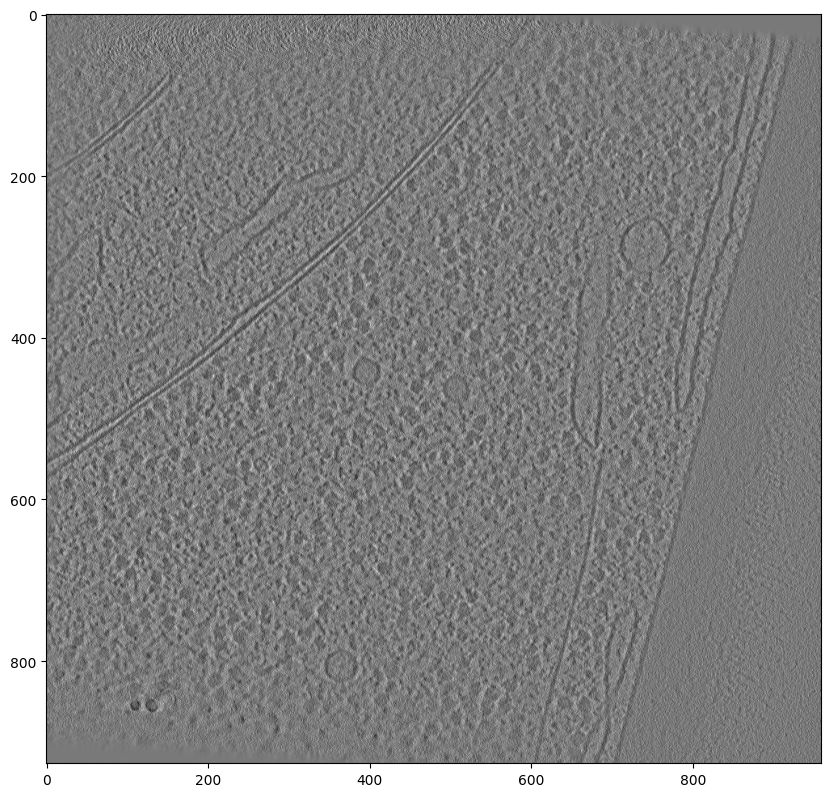

In [19]:
plt.imshow(b[b.shape[0] // 2], cmap='gray')

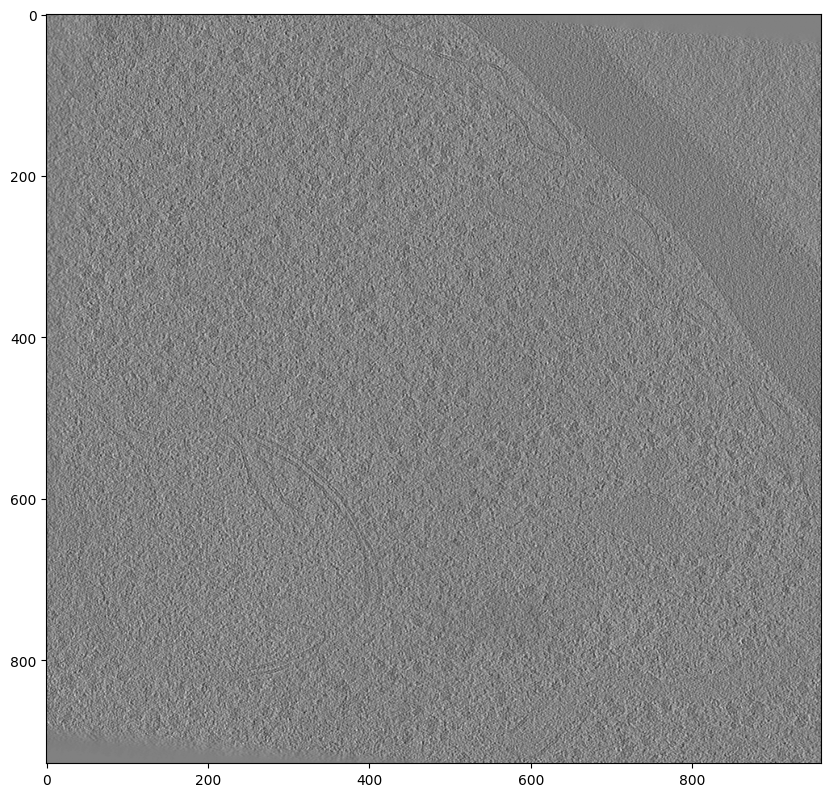

In [9]:
plt.imshow(a[a.shape[0] //2], cmap='gray')

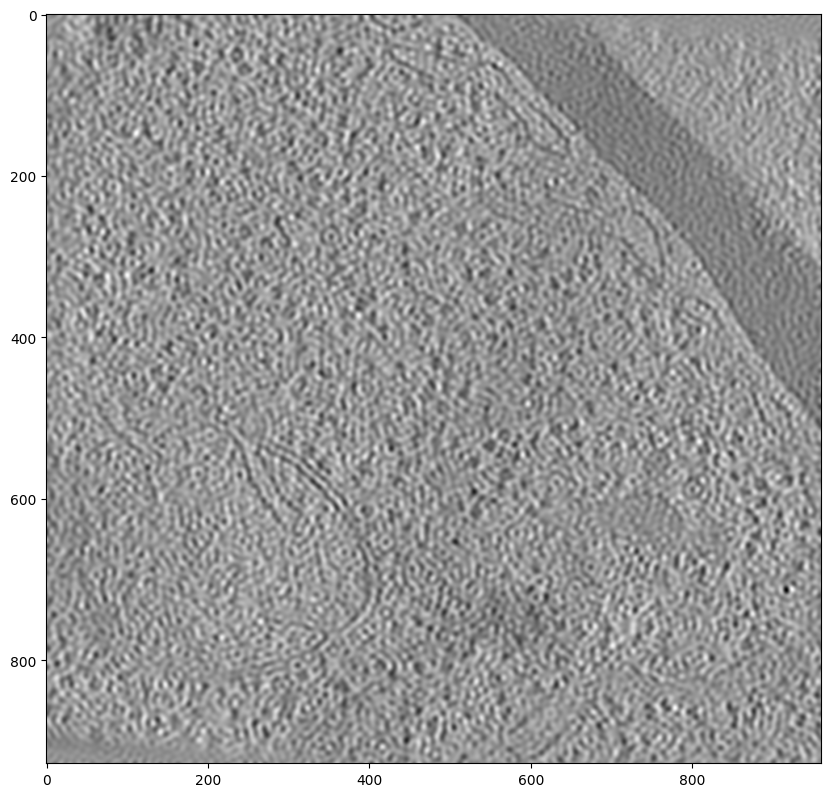

In [5]:
plt.imshow(low_pass_filter(a, radius=100)[a.shape[0] // 2], cmap='gray')

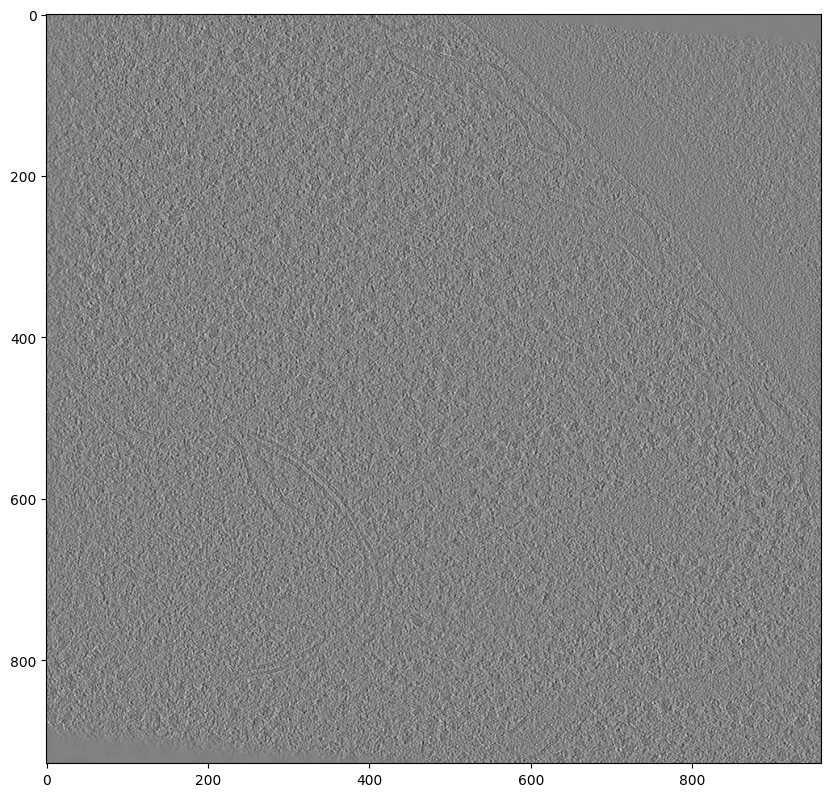

In [27]:
plt.imshow(high_pass_filter(a, radius=30)[a.shape[0] // 2], cmap='gray')

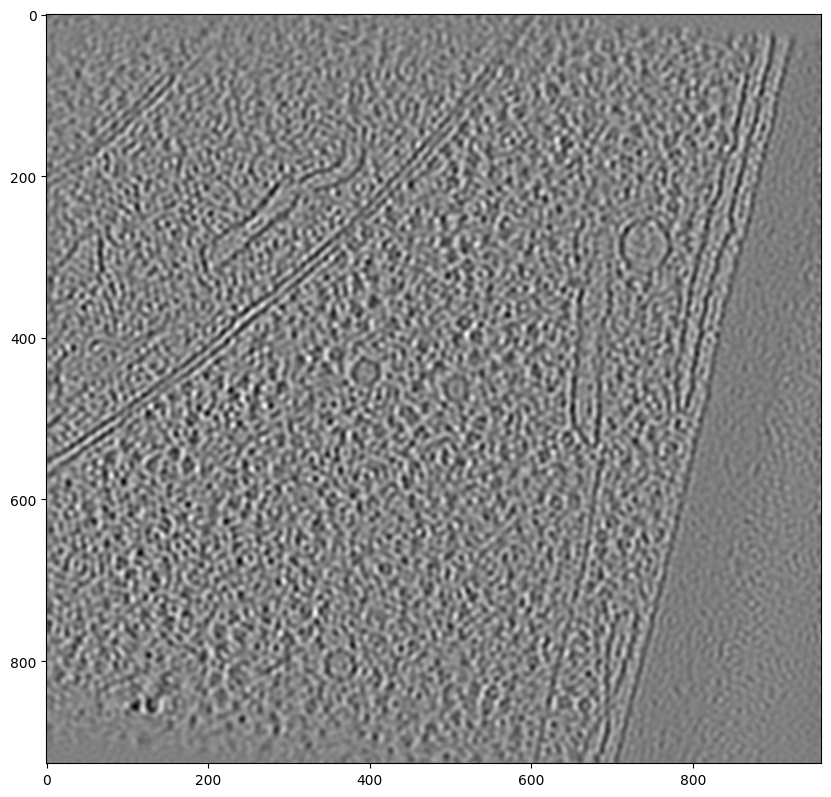

In [10]:
plt.imshow(low_pass_filter(b, radius=100)[b.shape[0] // 2], cmap='gray')

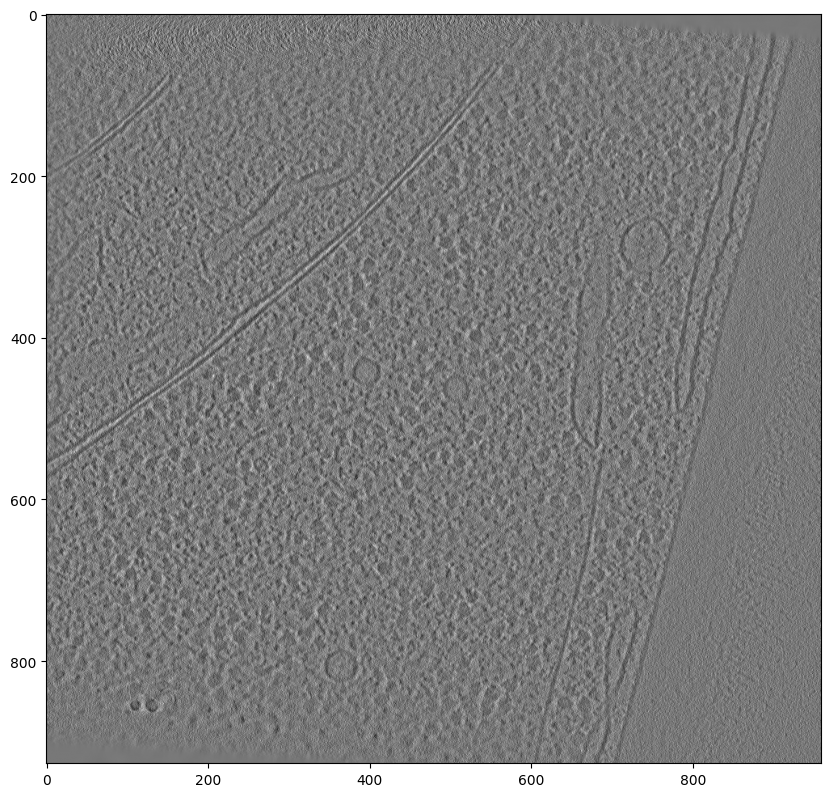

In [26]:
plt.imshow(high_pass_filter(b, radius=30)[b.shape[0] // 2], cmap='gray')

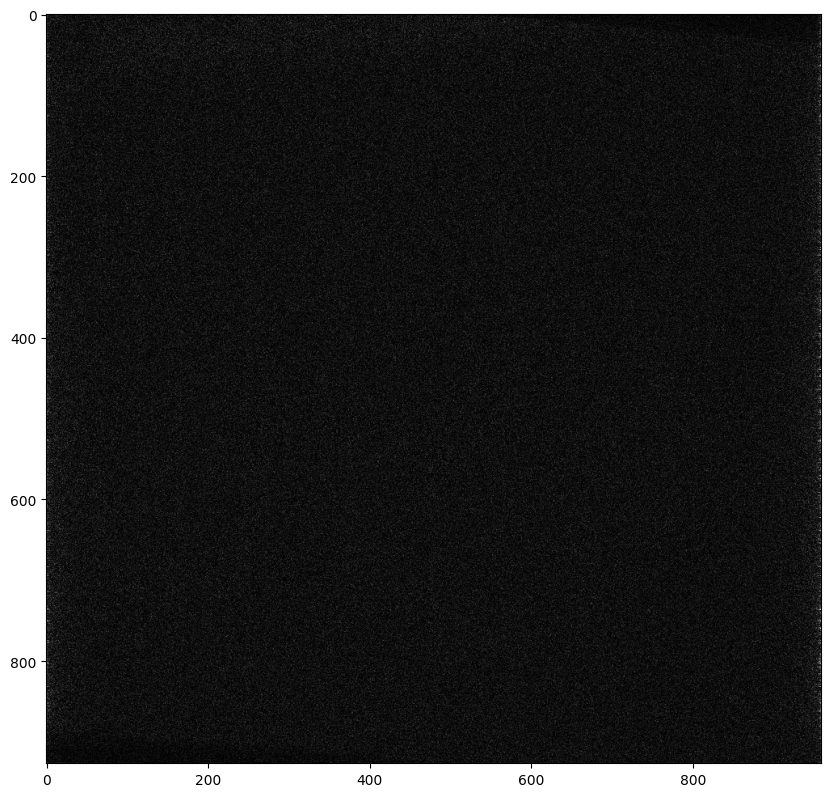

In [25]:
plt.imshow(np.abs(normalize_amplitudes(b)[b.shape[0] // 2]), cmap='gray')